# Generative Models
***

**ITMO University, Autumn 2022, MSc course**


## Assignment 1

***


*Authored by Arip Asadulaev & Manh Lab*

*Adapted by Alexander Panfilov*

***


The assignment is split into two parts: at first, you will implement classical GAN for the MNIST dataset, and after, you will enhance your results with DCGAN and the CIFAR10 dataset. 

Good luck!

## 1. GAN
*Source: <a href="https://arxiv.org/pdf/1406.2661.pdf" target="_blank">Goodfellow, Ian J., et al. "Generative Adversarial Networks." arXiv preprint arXiv:1406.2661 (2014)</a>.*

In 2014, Ian Goodfellow and his colleagues at the University of Montreal published a stunning paper introducing the world to GANs, or generative adversarial networks. The models play two distinct (literally, adversarial) roles. Given some real data set $\mathcal{X}$, $G$ is the generator, trying to create fake data that looks just like the genuine data, while $D$ is the discriminator, getting data from either the real set or $G$ and labeling the difference.

Goodfellow’s metaphor (and a fine one it is) was that $G$ was like a team of forgers trying to match real paintings with their output, while $D$ was the team of detectives trying to tell the difference. (Except in this case, the forgers $G$ never get to see the original data — only the judgments of $D$. They’re like blind forgers.)

<img src="https://production-media.paperswithcode.com/methods/gan.jpeg" style="display=block; margin:auto"/>
<p style="text-align: center">
    <b>Picture taken from the <a href="https://paperswithcode.com/method/gan" target="_blank">paperswithcode</a> website. There you can find a whole bunch of papers on GANs with implementation.</b>
</p>

In this part, we are going to implement classical GAN. You can find a rough plan on how to do it below; however, it is not mandatory to stick with it precisely but one might expect some questions related to the listed steps. Feel free to adapt provided code!

- Define the parameters
- Load the data (with transforms and normalization)
- Denormalize for visual inspection of samples
- Define the Discriminator network, the Generator network
- Study the activation function: Leaky ReLU
- Explain the output activation function: Tanh, Sigmoid
- Look at some sample outputs
- Define losses, optimizers and helper functions for training
     - For Discriminator
     - For Generator
- Train the model
- Save intermediate generated images to file
- Look at some outputs
- Save the models

### Imports

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
from torchvision.datasets import CIFAR10, MNIST
from torchvision.transforms import Compose, Normalize, ToTensor, ToPILImage
from torchvision.utils import save_image
from torch import optim
from typing import Tuple
from tqdm.auto import tqdm

%matplotlib inline
plt.style.use("ggplot")

### Define parameters & data loading 

In [2]:
hidden_size = 256
batch_size = 100
adam_lr = 0.0002
sqd_lr = 0.01
num_epochs = 300
sample_dir = './images'
latent_size = 64  # input random input vector latent
image_size = 784  # 28*28 flatten
device = 'cuda' if torch.cuda.is_available() else 'cpu'

if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)
## Define the dataset
mnist_dataset = MNIST(
    root='data',
    train=True,
    download=True,
    transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]),
)

Label:  5


(array([55.,  4.,  3.,  0.,  3.,  2.,  1.,  0.,  1.,  3.,  1.,  3.,  2.,
         1., 21.]),
 array([-1.        , -0.86771244, -0.73542482, -0.60313725, -0.47084966,
        -0.3385621 , -0.20627451, -0.07398693,  0.05830066,  0.19058824,
         0.32287583,  0.45516339,  0.58745098,  0.71973854,  0.85202616,
         0.98431373]),
 <BarContainer object of 15 artists>)

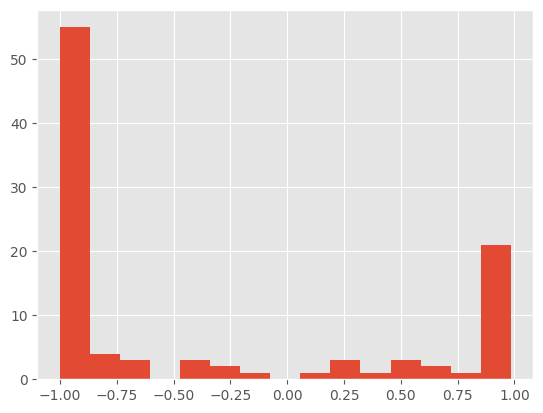

In [3]:
img, label = mnist_dataset[0]
print('Label: ', label)
plt.hist(img[:, 5:15, 5:15].flatten(), bins=15)

In [4]:
def denorm(x) -> torch.Tensor:
    return Normalize(mean=(-1,), std=(2,))(x)

denorm(img)

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

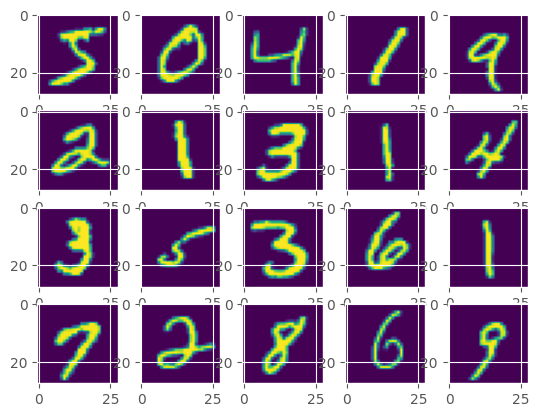

In [5]:
for i in range(20):
    image, label = mnist_dataset[i]
    plt.subplot(4, 5, i + 1)
    plt.imshow(denorm(image).permute(1, 2, 0))

In [6]:
mnist_dataset_loader = torch.utils.data.DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True)

### GAN implementation

GAN consists of two deep networks, a generator ($G$) and a discriminator ($D$). The generator creates images before learning it. Since the discriminator is a binary classification model, we can use the binary cross-entropy loss function to quantify how well it can distinguish between real and generated images.

In [7]:
class Generator(nn.Module):
    def __init__(self, latent_size, image_size, hidden_size) -> None:
        super(Generator, self).__init__()
        self.input_layer = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.LeakyReLU())
        self.hidden_layer = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU())
        self.output_layer = nn.Sequential(
            nn.Linear(hidden_size, image_size),
            nn.Tanh())

    def forward(self, x) -> torch.Tensor:
        x = self.input_layer(x)
        x = self.hidden_layer(x)
        x = self.output_layer(x)
        return x


class Discriminator(nn.Module):
    def __init__(self, image_size, hidden_size) -> None:
        super(Discriminator, self).__init__()
        self.input_layer = nn.Sequential(
            nn.Linear(image_size, hidden_size),
            nn.LeakyReLU())
        self.hidden_layer = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU())
        self.output_layer = nn.Sequential(
            nn.Linear(hidden_size, 1),
            nn.Sigmoid())
    def forward(self, x) -> torch.Tensor:
        x = self.input_layer(x)
        x = self.hidden_layer(x)
        x = self.output_layer(x)
        return x

### Create the Generator and Discriminator

In [8]:
generator = Generator(latent_size, image_size, hidden_size)
discriminator = Discriminator(image_size, hidden_size)

In [9]:
# show the output of model
y = generator(torch.randn(2, latent_size))
discriminator(y)

tensor([[0.4911],
        [0.4917]], grad_fn=<SigmoidBackward0>)

In [10]:
loss_function = nn.BCELoss()

In [11]:
generator_optimizer = optim.Adam(generator.parameters(), lr=adam_lr)
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=adam_lr)
# discriminator_optimizer = optim.SGD(discriminator.parameters(), lr=sqd_lr)

Discriminator Training

In [12]:
def train_discriminator(
    discriminator, 
    generator, 
    discriminator_optimizer,
    loss_function,
    real_images, 
    device, 
    batch_size, 
    latent_size
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    discriminator_optimizer.zero_grad()
    
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)
        
    real_predictions = discriminator(real_images)
    real_images_loss = loss_function(real_predictions, real_labels)
    
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = generator(z)
    fake_predictions = discriminator(fake_images)
    fake_images_loss = loss_function(fake_predictions, fake_labels)

    loss = real_images_loss + fake_images_loss

    loss.backward()

    discriminator_optimizer.step()
    
    return loss, real_predictions, fake_predictions

Generator Training

In [13]:
def train_generator(
    discriminator,
    generator, 
    generator_optimizer, 
    loss_function,
    device, 
    batch_size, 
    latent_size
) -> Tuple[torch.Tensor, torch.Tensor]:
    generator_optimizer.zero_grad()
    
    labels = torch.ones(batch_size, 1).to(device)
    
    z = torch.randn(batch_size, latent_size).to(device)
#     z = torch.Tensor(np.random.normal(0, 1, (batch_size, latent_size))).to(device)
    images = generator(z)
    predictions = discriminator(images)
    
    loss = loss_function(predictions, labels)
    
    loss.backward()
    
    generator_optimizer.step()

    return loss, images

### Start the training proccess

In [14]:
def save_fake_images_mnist(
    generator, 
    epoch, 
    sample_dir, 
    device, 
    batch_size, 
    latent_size
) -> None:
    z = torch.randn(batch_size, latent_size).to(device)
#     z = torch.Tensor(np.random.normal(0, 1, (batch_size, latent_size))).to(device)
    fake_images = generator(z)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_images_file_name = f'fake_images-{epoch}.png'
    print("Saving", fake_images_file_name)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_images_file_name), nrow=10)

In [15]:
%%time
total_step = len(mnist_dataset_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []
generator.to(device)
discriminator.to(device)
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(mnist_dataset_loader):
        real_images = images.reshape(batch_size, -1).to(device)
        
        discriminator_loss, real_predictions, fake_predictions = train_discriminator(
            discriminator, 
            generator, 
            discriminator_optimizer,
            loss_function,
            real_images, 
            device, 
            batch_size, 
            latent_size)

        generator_loss, fake_images = train_generator(
            discriminator,
            generator, 
            generator_optimizer, 
            loss_function,
            device, 
            batch_size, 
            latent_size)

        # Inspect the losses
        if (i + 1) % 200 == 0:
            d_losses.append(discriminator_loss.item())
            g_losses.append(generator_loss.item())
            real_scores.append(real_predictions.mean().item())
            fake_scores.append(fake_predictions.mean().item())
            print(
                "Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}".format(
                    epoch,
                    num_epochs,
                    i + 1,
                    total_step,
                    discriminator_loss.item(),
                    generator_loss.item(),
                    real_predictions.mean().item(),
                    fake_predictions.mean().item(),
                )
            )
    save_fake_images_mnist(generator, epoch + 1, sample_dir, device, batch_size, latent_size)

Epoch [0/300], Step [200/600], d_loss: 0.0642, g_loss: 3.7165, D(x): 0.99, D(G(z)): 0.05
Epoch [0/300], Step [400/600], d_loss: 0.2538, g_loss: 4.3837, D(x): 0.91, D(G(z)): 0.13
Epoch [0/300], Step [600/600], d_loss: 0.0922, g_loss: 4.9056, D(x): 0.94, D(G(z)): 0.02
Saving fake_images-1.png
Epoch [1/300], Step [200/600], d_loss: 0.4162, g_loss: 3.2116, D(x): 0.92, D(G(z)): 0.25
Epoch [1/300], Step [400/600], d_loss: 0.1396, g_loss: 4.6654, D(x): 0.90, D(G(z)): 0.01
Epoch [1/300], Step [600/600], d_loss: 1.2123, g_loss: 2.2371, D(x): 0.85, D(G(z)): 0.57
Saving fake_images-2.png
Epoch [2/300], Step [200/600], d_loss: 0.4592, g_loss: 2.9907, D(x): 0.86, D(G(z)): 0.14
Epoch [2/300], Step [400/600], d_loss: 0.6052, g_loss: 2.4257, D(x): 0.86, D(G(z)): 0.27
Epoch [2/300], Step [600/600], d_loss: 0.8556, g_loss: 2.3716, D(x): 0.81, D(G(z)): 0.21
Saving fake_images-3.png
Epoch [3/300], Step [200/600], d_loss: 0.6113, g_loss: 1.9187, D(x): 0.84, D(G(z)): 0.22
Epoch [3/300], Step [400/600], d_lo

Epoch [28/300], Step [200/600], d_loss: 0.6041, g_loss: 3.3762, D(x): 0.84, D(G(z)): 0.11
Epoch [28/300], Step [400/600], d_loss: 0.4549, g_loss: 2.9196, D(x): 0.85, D(G(z)): 0.15
Epoch [28/300], Step [600/600], d_loss: 0.3895, g_loss: 3.5135, D(x): 0.87, D(G(z)): 0.15
Saving fake_images-29.png
Epoch [29/300], Step [200/600], d_loss: 0.5196, g_loss: 3.2616, D(x): 0.80, D(G(z)): 0.07
Epoch [29/300], Step [400/600], d_loss: 0.3030, g_loss: 3.5639, D(x): 0.89, D(G(z)): 0.11
Epoch [29/300], Step [600/600], d_loss: 0.3812, g_loss: 3.3889, D(x): 0.85, D(G(z)): 0.07
Saving fake_images-30.png
Epoch [30/300], Step [200/600], d_loss: 0.6295, g_loss: 2.8663, D(x): 0.78, D(G(z)): 0.12
Epoch [30/300], Step [400/600], d_loss: 0.7336, g_loss: 3.1912, D(x): 0.73, D(G(z)): 0.09
Epoch [30/300], Step [600/600], d_loss: 0.5540, g_loss: 2.6096, D(x): 0.86, D(G(z)): 0.22
Saving fake_images-31.png
Epoch [31/300], Step [200/600], d_loss: 0.4540, g_loss: 3.6937, D(x): 0.81, D(G(z)): 0.10
Epoch [31/300], Step [

Epoch [56/300], Step [200/600], d_loss: 0.5730, g_loss: 2.7056, D(x): 0.78, D(G(z)): 0.13
Epoch [56/300], Step [400/600], d_loss: 0.6852, g_loss: 2.3504, D(x): 0.93, D(G(z)): 0.31
Epoch [56/300], Step [600/600], d_loss: 0.6194, g_loss: 2.0233, D(x): 0.79, D(G(z)): 0.19
Saving fake_images-57.png
Epoch [57/300], Step [200/600], d_loss: 0.7419, g_loss: 2.1095, D(x): 0.80, D(G(z)): 0.22
Epoch [57/300], Step [400/600], d_loss: 0.6482, g_loss: 1.8886, D(x): 0.75, D(G(z)): 0.18
Epoch [57/300], Step [600/600], d_loss: 0.6482, g_loss: 1.8457, D(x): 0.81, D(G(z)): 0.24
Saving fake_images-58.png
Epoch [58/300], Step [200/600], d_loss: 0.5327, g_loss: 1.8676, D(x): 0.84, D(G(z)): 0.22
Epoch [58/300], Step [400/600], d_loss: 0.6606, g_loss: 2.1369, D(x): 0.79, D(G(z)): 0.22
Epoch [58/300], Step [600/600], d_loss: 0.7969, g_loss: 2.1164, D(x): 0.70, D(G(z)): 0.16
Saving fake_images-59.png
Epoch [59/300], Step [200/600], d_loss: 0.6465, g_loss: 1.9235, D(x): 0.84, D(G(z)): 0.26
Epoch [59/300], Step [

Epoch [84/300], Step [200/600], d_loss: 0.8066, g_loss: 1.8301, D(x): 0.76, D(G(z)): 0.25
Epoch [84/300], Step [400/600], d_loss: 0.7403, g_loss: 1.9606, D(x): 0.77, D(G(z)): 0.25
Epoch [84/300], Step [600/600], d_loss: 0.7329, g_loss: 1.8757, D(x): 0.78, D(G(z)): 0.24
Saving fake_images-85.png
Epoch [85/300], Step [200/600], d_loss: 0.7426, g_loss: 1.7782, D(x): 0.75, D(G(z)): 0.24
Epoch [85/300], Step [400/600], d_loss: 0.8675, g_loss: 1.8723, D(x): 0.74, D(G(z)): 0.26
Epoch [85/300], Step [600/600], d_loss: 0.7067, g_loss: 1.9312, D(x): 0.76, D(G(z)): 0.23
Saving fake_images-86.png
Epoch [86/300], Step [200/600], d_loss: 0.8272, g_loss: 1.9012, D(x): 0.75, D(G(z)): 0.24
Epoch [86/300], Step [400/600], d_loss: 0.8090, g_loss: 1.7215, D(x): 0.76, D(G(z)): 0.29
Epoch [86/300], Step [600/600], d_loss: 0.6233, g_loss: 1.9583, D(x): 0.80, D(G(z)): 0.23
Saving fake_images-87.png
Epoch [87/300], Step [200/600], d_loss: 0.5707, g_loss: 1.9633, D(x): 0.84, D(G(z)): 0.23
Epoch [87/300], Step [

Epoch [111/300], Step [600/600], d_loss: 0.8429, g_loss: 1.5327, D(x): 0.79, D(G(z)): 0.36
Saving fake_images-112.png
Epoch [112/300], Step [200/600], d_loss: 0.7208, g_loss: 1.9575, D(x): 0.77, D(G(z)): 0.25
Epoch [112/300], Step [400/600], d_loss: 0.8219, g_loss: 1.6776, D(x): 0.75, D(G(z)): 0.29
Epoch [112/300], Step [600/600], d_loss: 0.7045, g_loss: 1.8845, D(x): 0.81, D(G(z)): 0.28
Saving fake_images-113.png
Epoch [113/300], Step [200/600], d_loss: 0.6190, g_loss: 1.8585, D(x): 0.77, D(G(z)): 0.20
Epoch [113/300], Step [400/600], d_loss: 0.8314, g_loss: 1.7435, D(x): 0.70, D(G(z)): 0.23
Epoch [113/300], Step [600/600], d_loss: 0.8410, g_loss: 1.6277, D(x): 0.79, D(G(z)): 0.30
Saving fake_images-114.png
Epoch [114/300], Step [200/600], d_loss: 0.6509, g_loss: 1.7356, D(x): 0.75, D(G(z)): 0.20
Epoch [114/300], Step [400/600], d_loss: 0.9403, g_loss: 1.5715, D(x): 0.69, D(G(z)): 0.26
Epoch [114/300], Step [600/600], d_loss: 0.8644, g_loss: 2.1133, D(x): 0.77, D(G(z)): 0.29
Saving fa

Epoch [139/300], Step [200/600], d_loss: 0.9018, g_loss: 1.6597, D(x): 0.70, D(G(z)): 0.26
Epoch [139/300], Step [400/600], d_loss: 0.8603, g_loss: 1.5827, D(x): 0.71, D(G(z)): 0.26
Epoch [139/300], Step [600/600], d_loss: 0.8067, g_loss: 1.7534, D(x): 0.75, D(G(z)): 0.30
Saving fake_images-140.png
Epoch [140/300], Step [200/600], d_loss: 0.7878, g_loss: 1.8839, D(x): 0.74, D(G(z)): 0.22
Epoch [140/300], Step [400/600], d_loss: 0.6960, g_loss: 1.7624, D(x): 0.81, D(G(z)): 0.28
Epoch [140/300], Step [600/600], d_loss: 0.6437, g_loss: 1.7970, D(x): 0.77, D(G(z)): 0.23
Saving fake_images-141.png
Epoch [141/300], Step [200/600], d_loss: 0.7483, g_loss: 1.9942, D(x): 0.76, D(G(z)): 0.25
Epoch [141/300], Step [400/600], d_loss: 0.7890, g_loss: 1.8658, D(x): 0.73, D(G(z)): 0.22
Epoch [141/300], Step [600/600], d_loss: 0.7289, g_loss: 1.5788, D(x): 0.78, D(G(z)): 0.26
Saving fake_images-142.png
Epoch [142/300], Step [200/600], d_loss: 0.7376, g_loss: 1.7080, D(x): 0.76, D(G(z)): 0.23
Epoch [14

Epoch [166/300], Step [600/600], d_loss: 0.7836, g_loss: 1.5876, D(x): 0.80, D(G(z)): 0.31
Saving fake_images-167.png
Epoch [167/300], Step [200/600], d_loss: 0.6925, g_loss: 1.5017, D(x): 0.76, D(G(z)): 0.26
Epoch [167/300], Step [400/600], d_loss: 0.8596, g_loss: 1.6015, D(x): 0.76, D(G(z)): 0.30
Epoch [167/300], Step [600/600], d_loss: 0.8655, g_loss: 1.5399, D(x): 0.77, D(G(z)): 0.33
Saving fake_images-168.png
Epoch [168/300], Step [200/600], d_loss: 0.6887, g_loss: 1.8968, D(x): 0.84, D(G(z)): 0.29
Epoch [168/300], Step [400/600], d_loss: 0.8869, g_loss: 1.7203, D(x): 0.70, D(G(z)): 0.24
Epoch [168/300], Step [600/600], d_loss: 0.8199, g_loss: 1.5946, D(x): 0.76, D(G(z)): 0.29
Saving fake_images-169.png
Epoch [169/300], Step [200/600], d_loss: 0.8162, g_loss: 2.0517, D(x): 0.71, D(G(z)): 0.22
Epoch [169/300], Step [400/600], d_loss: 0.7438, g_loss: 2.0554, D(x): 0.73, D(G(z)): 0.22
Epoch [169/300], Step [600/600], d_loss: 0.7986, g_loss: 1.3294, D(x): 0.71, D(G(z)): 0.23
Saving fa

Epoch [194/300], Step [200/600], d_loss: 0.8401, g_loss: 1.9681, D(x): 0.74, D(G(z)): 0.21
Epoch [194/300], Step [400/600], d_loss: 0.8074, g_loss: 1.4324, D(x): 0.75, D(G(z)): 0.27
Epoch [194/300], Step [600/600], d_loss: 0.8280, g_loss: 2.0046, D(x): 0.72, D(G(z)): 0.23
Saving fake_images-195.png
Epoch [195/300], Step [200/600], d_loss: 0.8233, g_loss: 1.5645, D(x): 0.70, D(G(z)): 0.25
Epoch [195/300], Step [400/600], d_loss: 0.7286, g_loss: 1.6291, D(x): 0.78, D(G(z)): 0.25
Epoch [195/300], Step [600/600], d_loss: 0.7196, g_loss: 1.4551, D(x): 0.81, D(G(z)): 0.31
Saving fake_images-196.png
Epoch [196/300], Step [200/600], d_loss: 0.5614, g_loss: 1.9586, D(x): 0.81, D(G(z)): 0.20
Epoch [196/300], Step [400/600], d_loss: 0.9371, g_loss: 1.8586, D(x): 0.71, D(G(z)): 0.27
Epoch [196/300], Step [600/600], d_loss: 0.7090, g_loss: 1.9056, D(x): 0.72, D(G(z)): 0.18
Saving fake_images-197.png
Epoch [197/300], Step [200/600], d_loss: 0.7363, g_loss: 1.7165, D(x): 0.75, D(G(z)): 0.24
Epoch [19

Epoch [221/300], Step [600/600], d_loss: 0.6372, g_loss: 1.4382, D(x): 0.83, D(G(z)): 0.24
Saving fake_images-222.png
Epoch [222/300], Step [200/600], d_loss: 0.8000, g_loss: 2.0601, D(x): 0.71, D(G(z)): 0.19
Epoch [222/300], Step [400/600], d_loss: 0.6626, g_loss: 1.8450, D(x): 0.77, D(G(z)): 0.23
Epoch [222/300], Step [600/600], d_loss: 0.7595, g_loss: 1.8257, D(x): 0.76, D(G(z)): 0.25
Saving fake_images-223.png
Epoch [223/300], Step [200/600], d_loss: 0.7735, g_loss: 2.1355, D(x): 0.70, D(G(z)): 0.19
Epoch [223/300], Step [400/600], d_loss: 0.8386, g_loss: 1.8588, D(x): 0.76, D(G(z)): 0.26
Epoch [223/300], Step [600/600], d_loss: 0.6661, g_loss: 1.6367, D(x): 0.84, D(G(z)): 0.29
Saving fake_images-224.png
Epoch [224/300], Step [200/600], d_loss: 0.8649, g_loss: 1.7669, D(x): 0.73, D(G(z)): 0.24
Epoch [224/300], Step [400/600], d_loss: 0.7420, g_loss: 1.5442, D(x): 0.81, D(G(z)): 0.30
Epoch [224/300], Step [600/600], d_loss: 0.7219, g_loss: 1.7827, D(x): 0.82, D(G(z)): 0.29
Saving fa

Epoch [249/300], Step [200/600], d_loss: 0.7045, g_loss: 1.8899, D(x): 0.76, D(G(z)): 0.22
Epoch [249/300], Step [400/600], d_loss: 0.6463, g_loss: 1.7634, D(x): 0.79, D(G(z)): 0.23
Epoch [249/300], Step [600/600], d_loss: 0.6821, g_loss: 1.8160, D(x): 0.80, D(G(z)): 0.25
Saving fake_images-250.png
Epoch [250/300], Step [200/600], d_loss: 0.7581, g_loss: 1.9371, D(x): 0.75, D(G(z)): 0.25
Epoch [250/300], Step [400/600], d_loss: 0.7017, g_loss: 2.2844, D(x): 0.76, D(G(z)): 0.21
Epoch [250/300], Step [600/600], d_loss: 0.7899, g_loss: 1.6626, D(x): 0.79, D(G(z)): 0.28
Saving fake_images-251.png
Epoch [251/300], Step [200/600], d_loss: 0.6233, g_loss: 1.4959, D(x): 0.82, D(G(z)): 0.24
Epoch [251/300], Step [400/600], d_loss: 0.7134, g_loss: 2.2543, D(x): 0.75, D(G(z)): 0.18
Epoch [251/300], Step [600/600], d_loss: 0.7351, g_loss: 1.5534, D(x): 0.81, D(G(z)): 0.27
Saving fake_images-252.png
Epoch [252/300], Step [200/600], d_loss: 0.6383, g_loss: 1.8072, D(x): 0.74, D(G(z)): 0.19
Epoch [25

Epoch [276/300], Step [600/600], d_loss: 0.6537, g_loss: 2.1679, D(x): 0.74, D(G(z)): 0.18
Saving fake_images-277.png
Epoch [277/300], Step [200/600], d_loss: 0.5824, g_loss: 1.9641, D(x): 0.81, D(G(z)): 0.20
Epoch [277/300], Step [400/600], d_loss: 0.6093, g_loss: 2.0903, D(x): 0.79, D(G(z)): 0.21
Epoch [277/300], Step [600/600], d_loss: 0.6921, g_loss: 1.3327, D(x): 0.84, D(G(z)): 0.32
Saving fake_images-278.png
Epoch [278/300], Step [200/600], d_loss: 0.7075, g_loss: 1.7692, D(x): 0.78, D(G(z)): 0.24
Epoch [278/300], Step [400/600], d_loss: 0.7130, g_loss: 1.8534, D(x): 0.75, D(G(z)): 0.20
Epoch [278/300], Step [600/600], d_loss: 0.5929, g_loss: 1.5743, D(x): 0.79, D(G(z)): 0.20
Saving fake_images-279.png
Epoch [279/300], Step [200/600], d_loss: 0.5777, g_loss: 1.9060, D(x): 0.80, D(G(z)): 0.19
Epoch [279/300], Step [400/600], d_loss: 0.7401, g_loss: 1.6855, D(x): 0.79, D(G(z)): 0.24
Epoch [279/300], Step [600/600], d_loss: 0.5930, g_loss: 2.3618, D(x): 0.81, D(G(z)): 0.17
Saving fa

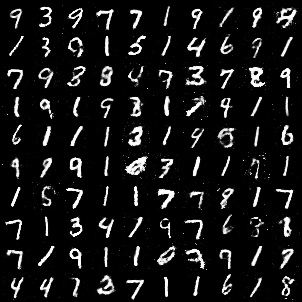

In [16]:
# show output after epochs training
Image.open(os.path.join(sample_dir, 'fake_images-200.png'))

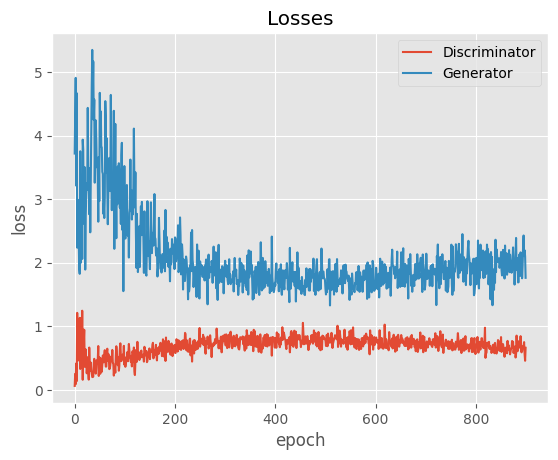

In [17]:
# show the discrimator loss and generator loss
plt.plot(d_losses, "-")
plt.plot(g_losses, "-")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["Discriminator", "Generator"])
plt.title("Losses");

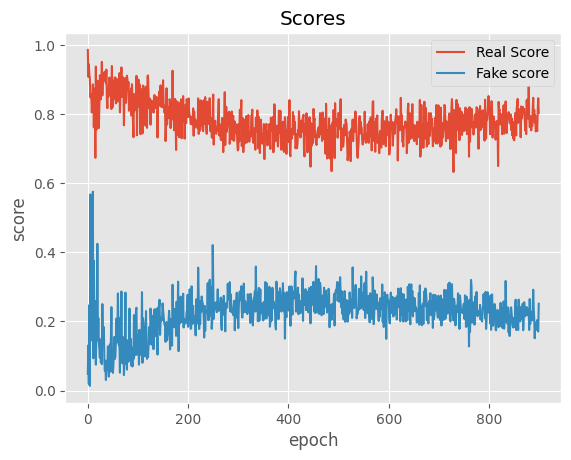

In [18]:
# plot the accuracy of discrimator
plt.plot(real_scores, "-")
plt.plot(fake_scores, "-")
plt.xlabel("epoch")
plt.ylabel("score")
plt.legend(["Real Score", "Fake score"])
plt.title("Scores");

## 2. DCGAN

*Source: <a href="https://arxiv.org/pdf/1511.06434v2.pdf" target="_blank">Radford, Alec, Luke Metz, and Soumith Chintala. "Unsupervised representation learning with deep convolutional generative adversarial networks." arXiv preprint arXiv:1511.06434 (2015)</a>.*

The goal of this part is to enhance your results achieved in the part one with DCGAN. Feel free to reuse your code, improve architecture or training scheme, etc.

In [ ]:
class CFG:
    batch_size = 128
    num_epochs = 300
    workers = 4
    seed = 2021
    image_size = 64
    download = True
    dataroot = 'data'
    nc = 3  ## number chanels
    ngf = 64  # Size of feature maps in generator
    nz = 100  # latent random input vector
    ndf = 64  # Size of feature maps in discriminator
    lr = 0.0002
    device = 'cpu'
    sample_dir = './dcgan_images/'


if not os.path.exists(CFG.sample_dir):
    os.makedirs(CFG.sample_dir)

cifar_dataset = CIFAR10(
    root=CFG.dataroot,
    download=CFG.download,
    transform=transforms.Compose(
        [
            transforms.Resize([CFG.image_size, CFG.image_size]),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    ),
)

In [ ]:
img, label = cifar_dataset[0]
print("Label: ", label)
plt.hist(img[:, 5:15, 5:15].flatten(), bins=15)

In [ ]:
for i in range(20):
    image, label = cifar_dataset[i]
    plt.subplot(4, 5, i + 1)
    plt.imshow(denorm(image).permute(1, 2, 0))

In [ ]:
cifar_dataset_loader = torch.utils.data.DataLoader(cifar_dataset, batch_size=CFG.batch_size, shuffle=True)

### DCGAN implementation

In [ ]:
class DCGenerator(nn.Module):
    def __init__(self, nc, nz, ngf):
        # ConvTranspose2d - BatchNorm - Relu -ConvTranspose2d - BatchNorm - Relu -ConvTranspose2d - BatchNorm - Relu
        # ConvTranspose2d - BatchNorm - Relu - ConvTranspose2d - Tanh
        super(Generator, self).__init__()
        ##

    def forward(self, x):
        ##
        return F.tanh(x)


class DCDiscriminator(nn.Module):
    def __init__(self, nc, ndf):
        # conv2d - leaky - conv2d - batchnorm - leaky - conv2d - batchnorm - leaky - conv - batchnorm - leaky - conv2d
        super(Discriminator, self).__init__()
        ##

    def forward(self, x):
        ##
        return F.sigmoid(x)

In [ ]:
# create new Generator model

# DCG = DCGenerator...

# create new Discriminator model

# DCD = DCDiscriminator...

In [ ]:
# show the output of model
y = DCG(torch.randn(2, CFG.latent_size))

In [ ]:
# define the criterion is nn.BCELoss()
criterion = nn.BCELoss()
## Define the optimizer for generator and discrimator

In [ ]:
# feel free to reuse your training functions

### Start the training proccess

In [ ]:
def save_fake_images_cifar(DCG_model, index, device=CFG.device, sample_dir=CFG.sample_dir, batch_size=CFG.batch_size):
    sample_vectors = torch.randn(batch_size, CFG.nz, 1, 1).to(device)
    fake_images = DCG_model(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 3, 64, 64)
    fake_fname = "fake_images-{0:0=4d}.png".format(index)
    print("Saving", fake_fname)
    save_image(
        denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10
    )

In [ ]:
%%time
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []
DCG.to(CFG.device)
DCD.to(CFG.device)
for epoch in range(CFG.num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(CFG.batch_size, -1).to(CFG.device)

        # Train the discriminator

        # Train the generator

        # Inspect the losses
        if (i + 1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print(
                "Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}".format(
                    epoch,
                    CFG.num_epochs,
                    i + 1,
                    total_step,
                    d_loss.item(),
                    g_loss.item(),
                    real_score.mean().item(),
                    fake_score.mean().item(),
                )
            )
    # Sample and save images
    save_fake_images_cifar(epoch + 1)

In [ ]:
# show your results!